# BifrequencyMap の基礎と応用

`BifrequencyMap` は、2つの周波数軸（入力周波数 $f_1$ と出力周波数 $f_2$）の間の関係を表すためのクラスです。
主に、非線形結合、アップコンバージョン、散乱行列、あるいはMIMO（多入力多出力）系の伝達関数などを表現するために使用されます。

このノートブックでは、`BifrequencyMap` の作成、可視化、および様々な解析機能（伝搬、畳み込み、統計量計算、スライス抽出）について解説します。

## 1. マップの作成

ここでは、複数の物理的な結合メカニズムが混在する複雑なシナリオを模擬したマップを作成します。

- **Input Axis ($f_1$)**: 環境物理量（磁場など）の周波数
- **Output Axis ($f_2$)**: ターゲット（重力波検出器など）の周波数

以下の3つの結合を含めます：
1.  **線形結合 (Linear Coupling)**: $f_2 = f_1$
    - 入力がそのまま出力に現れる成分
2.  **高調波結合 (Harmonic Coupling)**: $f_2 = 2 \cdot f_1$
    - 入力の2倍の周波数が出力に現れる非線形性
3.  **サイドバンド結合 (Sideband Coupling)**: $f_2 = f_1 \pm 10 	ext{Hz}$
    - 10Hzの変調によって生じるサイドバンド

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.frequencyseries import FrequencySeries
from gwexpy.frequencyseries import BifrequencyMap

# 1. 軸の定義
# 入力軸: 0-200Hz (分解能 0.5Hz)
f_in = np.linspace(0, 200, 401)

# 出力軸: 0-300Hz (分解能 0.5Hz)
f_out = np.linspace(0, 300, 601)

# 2. 応答関数マップの作成
coupling_matrix = np.zeros((len(f_out), len(f_in)))

# グリッド上でのインデックス計算用関数
def get_idx(freq, axis_array):
    return np.argmin(np.abs(axis_array - freq))

for i, f1_val in enumerate(f_in):
    # 1. 線形結合: f2 = f1
    # 範囲内であれば結合を追加
    if f1_val <= f_out[-1]:
        j = get_idx(f1_val, f_out)
        coupling_matrix[j, i] += 1e-22

    # 2. 高調波結合: f2 = 2 * f1
    f2_harm = 2 * f1_val
    if f2_harm <= f_out[-1]:
        j = get_idx(f2_harm, f_out)
        coupling_matrix[j, i] += 5e-23

    # 3. サイドバンド結合: f2 = f1 +/- 10Hz (50Hz < f1 < 150Hz の範囲で強く出ると仮定)
    if 50 < f1_val < 150:
        for offset in [-10, 10]:
            f2_sb = f1_val + offset
            if 0 <= f2_sb <= f_out[-1]:
                j = get_idx(f2_sb, f_out)
                coupling_matrix[j, i] += 1e-23

# BifrequencyMap インスタンス化
transfer_map = BifrequencyMap.from_points(
    coupling_matrix, 
    f2=f_out, 
    f1=f_in,
    name="Complex Coupling Map",
    unit="strain/T"
)

print(transfer_map)

BifrequencyMap([[1.5e-22 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-22 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 5.0e-23 1.0e-22 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]]
               unit: strain / T,
               freq1: 0.0 Hz .. 200.0 Hz,
               freq2: 0.0 Hz .. 300.0 Hz,
               name: Complex Coupling Map)


## 2. データの可視化

`plot()` メソッドを使用すると、マップを2次元のカラーマップとして可視化できます。
データが疎（スパース）な場合やダイナミックレンジが広い場合は、`LogNorm` を使用すると見やすくなります。

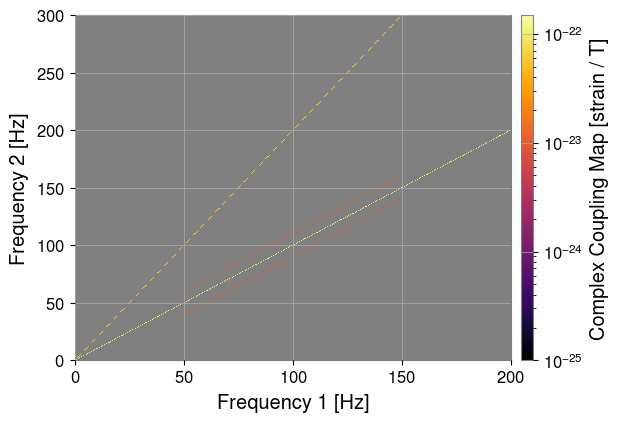

In [2]:
from matplotlib.colors import LogNorm

# norm='log' (LogNorm) を指定して対数スケールで表示
# vmin を適切に設定することで、バックグラウンドの0と信号を区別しやすくなります
plot = transfer_map.plot(norm=LogNorm(vmin=1e-25))
plot.show()

## 3. スペクトルの伝搬 (Propagation)

`propagate()` メソッドは、入力スペクトル $S_{	ext{in}}(f_1)$ をマップに通して、出力スペクトル $S_{	ext{out}}(f_2)$ を計算します。
例として、60Hzにピークを持つ入力スペクトルを伝搬させてみます。

FrequencySeries([7.49760292e-25, 4.92849164e-25, 5.45870202e-25,
                 ..., 2.93666658e-25, 0.00000000e+00,
                 3.30917550e-25]
                unit: strain,
                f0: 0.0 Hz,
                df: 0.5 Hz,
                epoch: None,
                name: Projected: Complex Coupling Map x Magnetometer,
                channel: None)


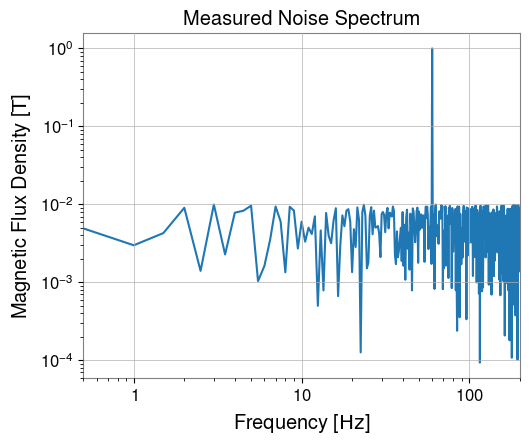

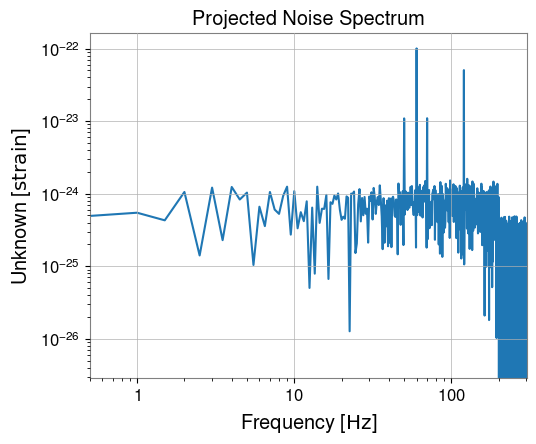

In [3]:
# 入力データの用意: 60Hz にラインノイズ
f_measured = np.linspace(0, 200, 401)
data = np.random.rand(401) * 1e-2  # フロア
data[get_idx(60, f_measured)] = 1.0 # 60Hz ピーク

measured_noise = FrequencySeries(
    data,
    frequencies=f_measured,
    unit="T",
    name="Magnetometer"
)

measured_noise.plot(title="Measured Noise Spectrum")
plt.yscale("log")

# 伝搬計算
projected_gw_noise = transfer_map.propagate(measured_noise)

print(projected_gw_noise)
projected_gw_noise.plot(title="Projected Noise Spectrum")
plt.yscale("log")

## 4. 畳み込み積分 (Convolution)

`convolute()` メソッドは、入力スペクトルとマップの畳み込み積分を行います。
$$ S_{	ext{out}}(f_2) = \int M(f_2, f_1) S_{	ext{in}}(f_1) df_1 $$
単位には $df_1$ の次元が含まれるようになります。

Convoluted Result Unit: Hz strain


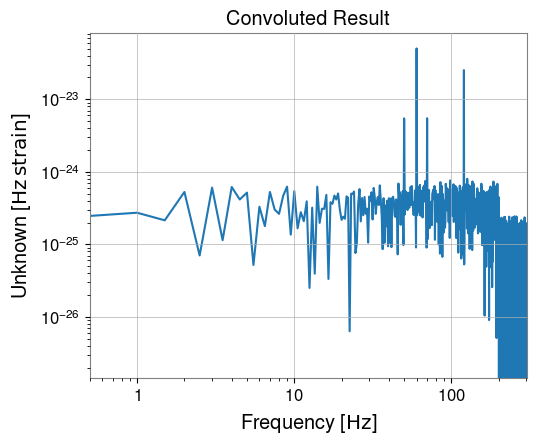

In [4]:
convoluted_result = transfer_map.convolute(measured_noise)
print("Convoluted Result Unit:", convoluted_result.unit)
convoluted_result.plot(title="Convoluted Result")
plt.yscale("log")

## 5. 統計的解析 (Diagonal Statistics)

`diagonal()` メソッドを使用すると、周波数差 $f_{	ext{diff}} = f_2 - f_1$ あるいは $|f_2 - f_1|$ に沿った統計量を計算できます。
今回の例では、線形結合 ($f_2-f_1=0$) やサイドバンド ($f_2-f_1=\pm 10$) が特徴として現れるはずです。

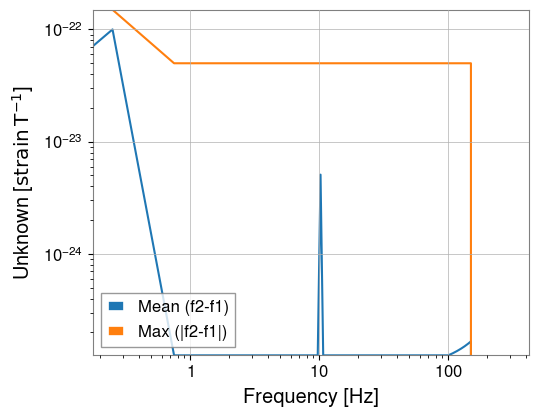

In [5]:
# f2 - f1 を横軸として平均値を計算
diag_mean = transfer_map.diagonal(method='mean')

# |f2 - f1| を横軸として最大値を計算
diag_abs_max = transfer_map.diagonal(method='max', absolute=True)

from gwexpy.plot import Plot
plot = Plot(diag_mean, diag_abs_max, label=["Mean (f2-f1)", "Max (|f2-f1|)"])
plot.show()

## 6. スライス抽出 (Slice Extraction)

`get_slice()` を使うと、特定の $f_1$ または $f_2$ における断面（1Dスペクトル）を抽出できます。

Slice at f1=60Hz: FrequencySeries([0., 0., 0., ..., 0., 0., 0.]
                unit: strain / T,
                f0: 0.0 Hz,
                df: 0.5 Hz,
                epoch: None,
                name: Complex Coupling Map (at f1=60.00 Hz),
                channel: None)


(2e-24, 5e-22)

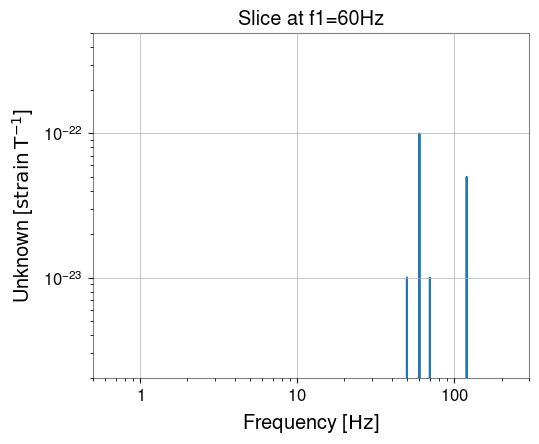

In [6]:
# f1 = 60Hz における断面 (横軸: f2)
# 期待値: 60Hz (線形), 120Hz (2倍高調波), 50/70Hz (サイドバンド10Hz)
slice_f1 = transfer_map.get_slice(at=60.0, axis='f1')

print("Slice at f1=60Hz:", slice_f1)
slice_f1.plot(title="Slice at f1=60Hz")
plt.yscale('log')
plt.ylim(2e-24,5e-22)

## 7. 1Dスペクトル重ね描き (Line Plots)

`plot_lines()` は、マップを多数の1Dプロットの集合として可視化します。

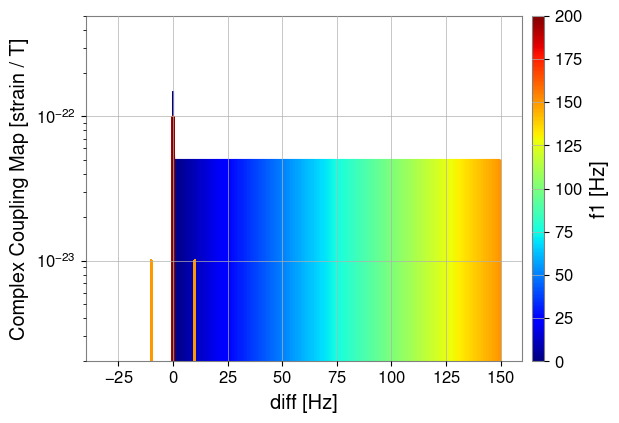

In [7]:
# f1 ごとに f2-f1 を横軸にとったプロット（色は f1）
plot = transfer_map.plot_lines(xaxis='diff', color='f1', cmap='jet')
plt.yscale('log')
plt.ylim(2e-24,5e-22)
plt.xlim(-40,160)
plt.show()